Score de Silhouette pour 4 clusters: 0.7501733656723456

Nombre de Clients par Segment:
                 Segment  Nombre de Clients
0        Client Régulier               1934
1        Client Prospect                808
2  Client à Forte Valeur                 19
3             Client VIP                  2

Statistiques descriptives par Segment:


Segment  Total_Montant_Mean  Total_Montant_Sum  \
0        Client Prospect        7.147819e+08       5.775438e+11   
1        Client Régulier        3.780358e+09       7.311213e+12   
2             Client VIP        6.463813e+11       1.292763e+12   
3  Client à Forte Valeur        1.947524e+11       3.700295e+12   

   Mean_Montant_Mean  Annees_Actives_Mean  
0       6.220907e+07             1.720297  
1       9.327343e+07             3.862461  
2       1.576540e+10             4.000000  
3       7.096607e+09             3.105263

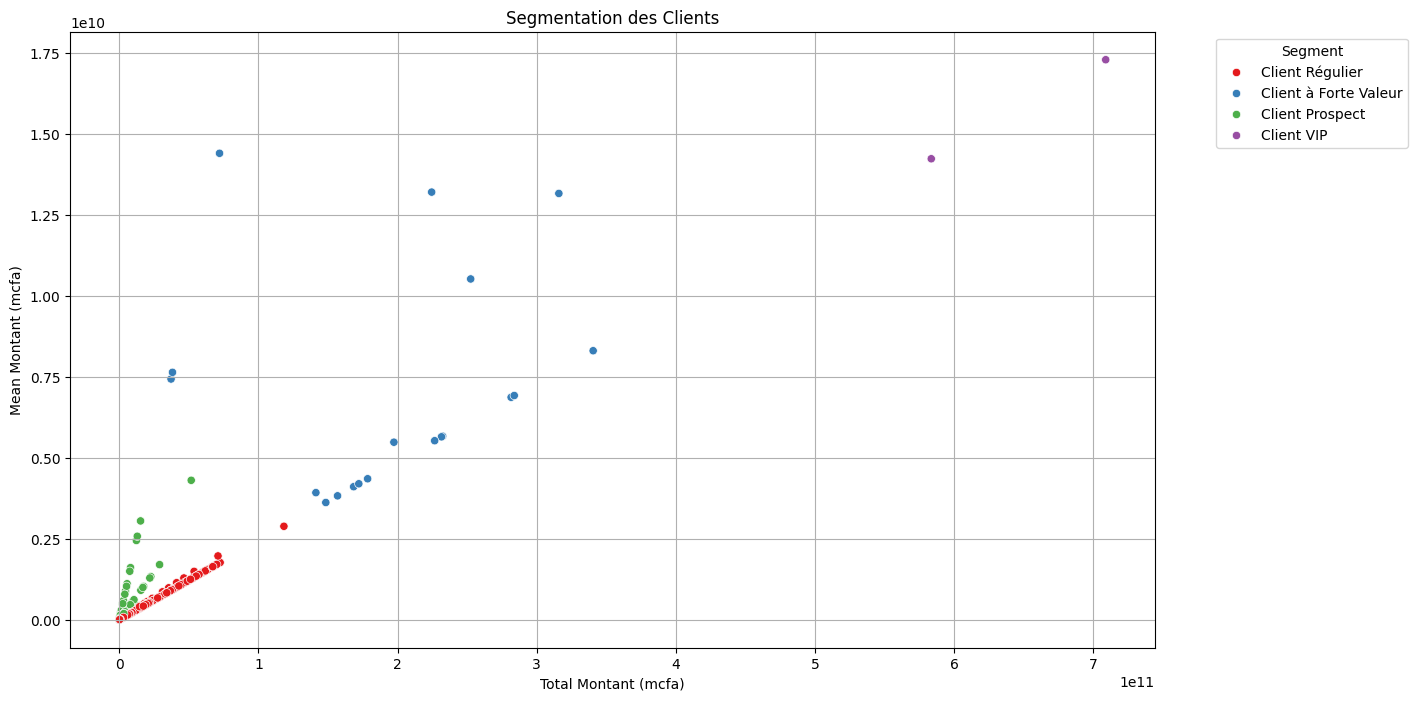

C:\Users\user\AppData\Local\Temp\ipykernel_25380\3364668469.py:102: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_clients_per_cluster = client_stats.groupby('Cluster').apply(lambda x: x.nlargest(10, 'Total_Montant')).reset_index(drop=True)
C:\Users\user\AppData\Local\Temp\ipykernel_25380\3364668469.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Montant', y='Nom client', data=cluster_data, ax=ax, palette='Set2')
C:\Users\user\AppData\Local\Temp\ipykernel_25380\3364668469.py:111: FutureWarning: 

Passing `palette` without assignin

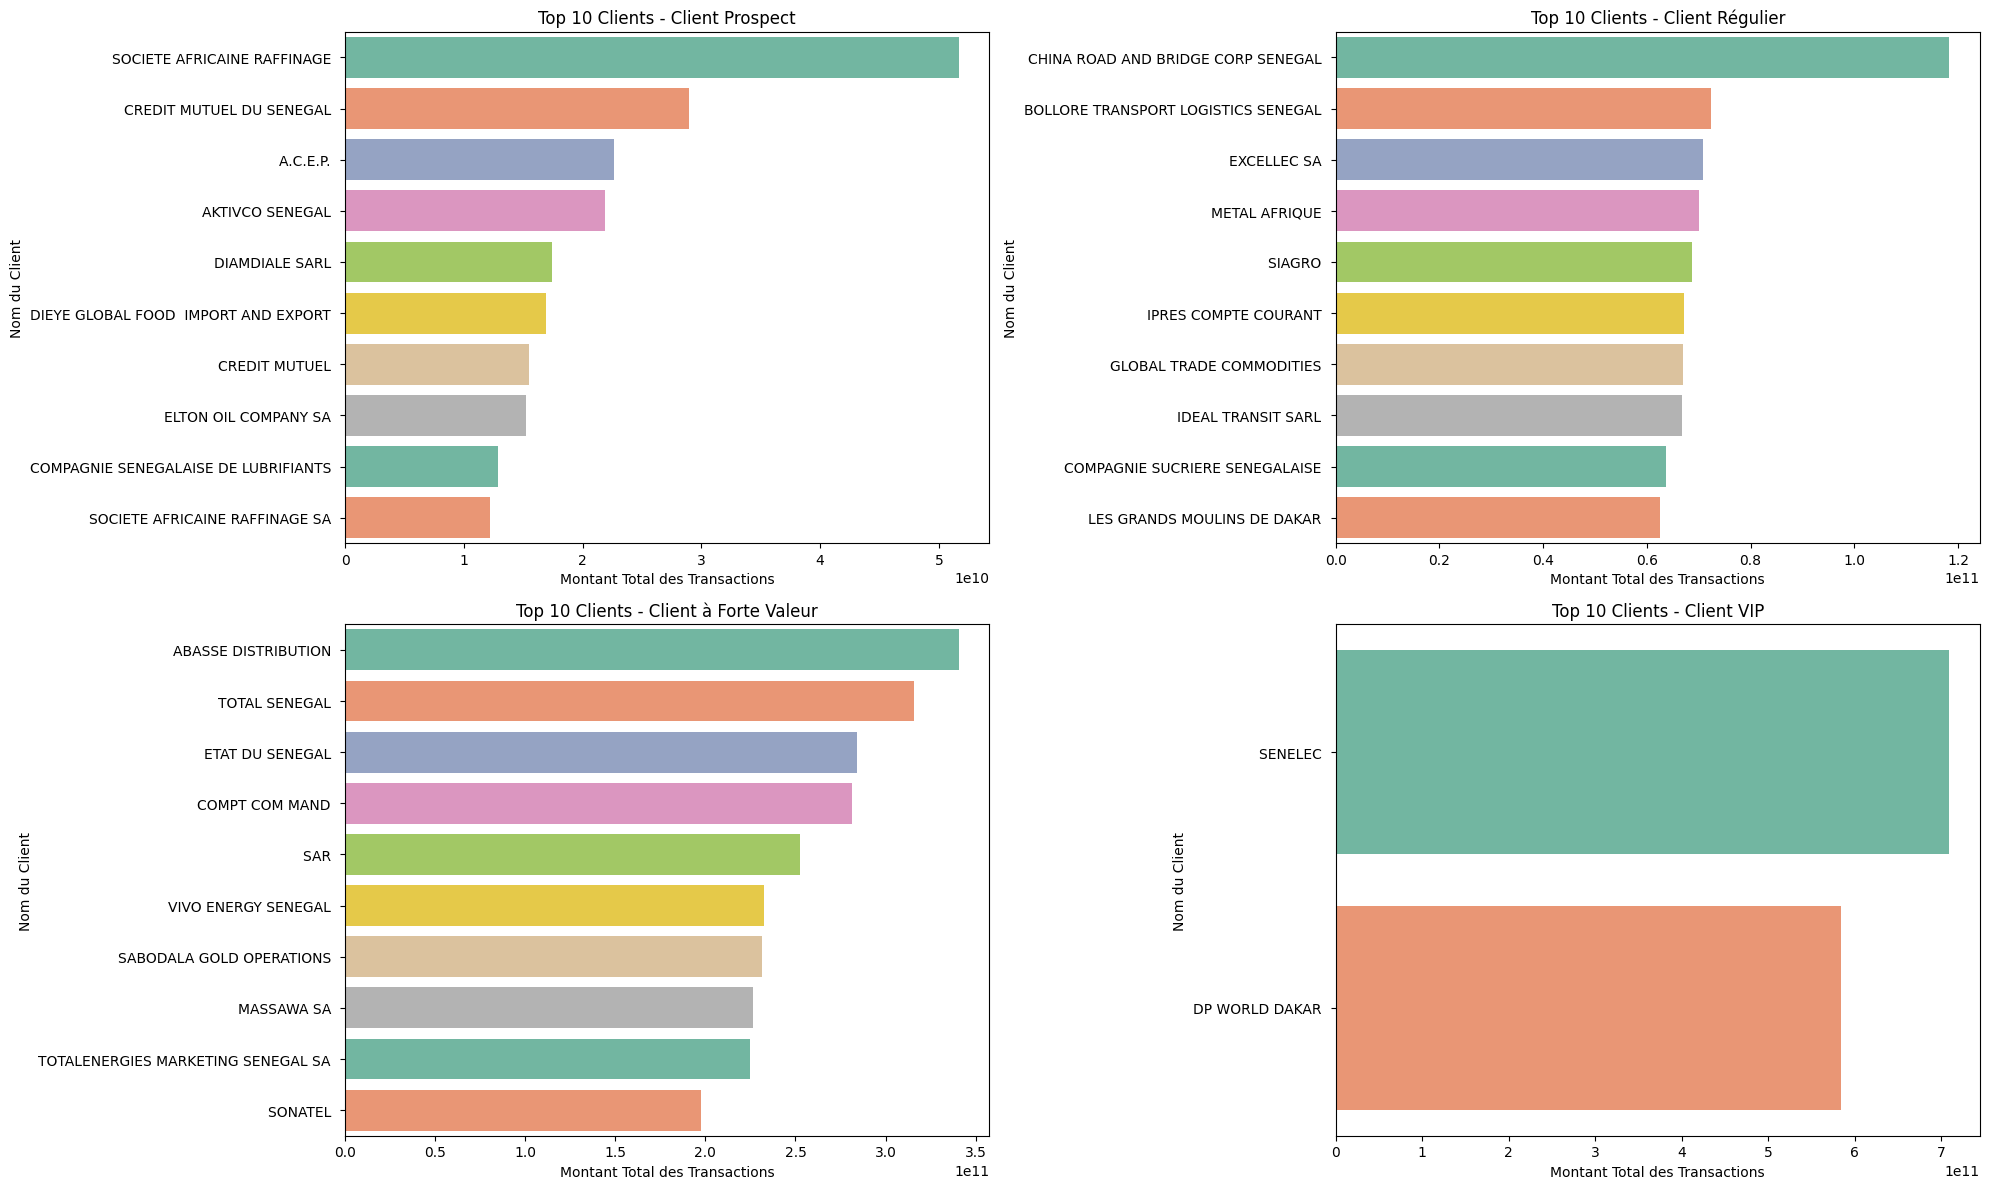

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Charger les données
file_path = 'Flux Crediteur_2021_2024_v1.xlsx'
data = pd.read_excel(file_path)

# Convertir la colonne 'Date' en format datetime
data['Date'] = pd.to_datetime(data['Date'])

# Extraire l'année des dates
data['Année'] = data['Date'].dt.year

# Calculer les caractéristiques des clients
client_stats = data.groupby(['Clients', 'Nom client']).agg(
    Total_Montant=('mcfa', 'sum'),
    Mean_Montant=('mcfa', 'mean'),
    Annees_Actives=('Année', 'nunique')
).reset_index()

# Standardiser les données
scaler = StandardScaler()
client_stats_scaled = scaler.fit_transform(client_stats[['Total_Montant', 'Mean_Montant', 'Annees_Actives']])

# Choisir 4 clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
client_stats['Cluster'] = kmeans.fit_predict(client_stats_scaled)

# Calculer le score de silhouette
silhouette_avg = silhouette_score(client_stats_scaled, client_stats['Cluster'])
print(f"Score de Silhouette pour {optimal_clusters} clusters: {silhouette_avg}")

# Calculer les statistiques descriptives pour chaque cluster
cluster_stats = client_stats.groupby('Cluster').agg(
    Total_Montant_Mean=('Total_Montant', 'mean'),
    Total_Montant_Sum=('Total_Montant', 'sum'),
    Mean_Montant_Mean=('Mean_Montant', 'mean'),
    Annees_Actives_Mean=('Annees_Actives', 'mean')
).reset_index()

#print("\nStatistiques descriptives par Cluster:")
#display(cluster_stats)

# Identifier les clusters en fonction des critères
cluster_stats_sorted = cluster_stats.sort_values(by=['Total_Montant_Mean', 'Annees_Actives_Mean'], ascending=[True, True]).reset_index(drop=True)

# Assigner les noms marketing
cluster_stats_sorted['Segment'] = ['Client Prospect', 'Client Régulier', 'Client à Forte Valeur', 'Client VIP']

# Créer un dictionnaire de mapping des clusters aux segments
cluster_mapping = dict(zip(cluster_stats_sorted['Cluster'], cluster_stats_sorted['Segment']))

# Appliquer le mapping des clusters
client_stats['Segment'] = client_stats['Cluster'].map(cluster_mapping)

# Afficher les résultats en précisant le nombre de clients par segment
segments_counts = client_stats['Segment'].value_counts().reset_index()
segments_counts.columns = ['Segment', 'Nombre de Clients']

# Calculer les statistiques descriptives pour chaque segment
segment_stats = client_stats.groupby('Segment').agg(
    Total_Montant_Mean=('Total_Montant', 'mean'),
    Total_Montant_Sum=('Total_Montant', 'sum'),
    Mean_Montant_Mean=('Mean_Montant', 'mean'),
    Annees_Actives_Mean=('Annees_Actives', 'mean')
).reset_index()

# Afficher les résultats
print("\nNombre de Clients par Segment:")
print(segments_counts)

print("\nStatistiques descriptives par Segment:")
display(segment_stats)

# Visualiser les segments
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Total_Montant', y='Mean_Montant', hue='Segment', data=client_stats, palette='Set1')
plt.title('Segmentation des Clients')
plt.xlabel('Total Montant (mcfa)')
plt.ylabel('Mean Montant (mcfa)')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Explication des segments
#segment_explanations = {
    #'Client Prospect': 'Clients avec un faible montant total moyen, actifs depuis peu.',
    #'Client Régulier': 'Clients avec un montant total moyen modéré, actifs régulièrement.',
    #'Client à Forte Valeur': 'Clients avec un montant total moyen élevé, mais moins actifs que les VIP.',
    #'Client VIP': 'Clients avec un montant total et moyen par transaction très élevés, actifs depuis longtemps.'
#}

#for segment, explanation in segment_explanations.items():
    #print(f"{segment}: {explanation}")

# Déterminer les top 10 clients par cluster
top_clients_per_cluster = client_stats.groupby('Cluster').apply(lambda x: x.nlargest(10, 'Total_Montant')).reset_index(drop=True)

# Créer des sous-graphes pour les top 10 clients de chaque cluster
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
clusters = top_clients_per_cluster['Cluster'].unique()

for i, cluster in enumerate(clusters):
    ax = axs[i // 2, i % 2]
    cluster_data = top_clients_per_cluster[top_clients_per_cluster['Cluster'] == cluster]
    sns.barplot(x='Total_Montant', y='Nom client', data=cluster_data, ax=ax, palette='Set2')
    ax.set_title(f'Top 10 Clients - {cluster_mapping[cluster]}')
    ax.set_xlabel('Montant Total des Transactions')
    ax.set_ylabel('Nom du Client')

plt.tight_layout()
plt.show()


